# Bank Churn prediction
 
### **Context**:

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### **Objective**:

Let us consider you are working as Data scientist with the  bank and you need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### **Data Dictionary**:

The case study is from an open-source dataset from Kaggle.The dataset contains 10,000 sample points with 14 distinct features as follows:

CustomerId: Unique ID which is assigned to each customer

Surname: Last name of the customer
 
CreditScore: It defines the credit history of the customer.
  
Geography: A customer’s location 
   
Gender: It defines the Gender of the customer
   
Age: Age of the customer 
    
Tenure: Number of years for which the customer has been with the bank

NumOfProducts: refers to the number of products that a customer has purchased through the bank.

Balance: Account balance

HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

EstimatedSalary: Estimated salary 

isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

Exited : whether or not the customer left the bank within six month. It can take two values 

0=No ( Customer did not leave the bank )
1=Yes ( Customer left the bank )



In [62]:
#importing tensorflow and checking its version
import tensorflow as tf
print(tf.__version__)
from numpy.random import seed
seed(1)


2.7.0


In [63]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np



#### Read the dataset

In [65]:
ds = pd.read_csv("bank.csv")

In [66]:
ds.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


#### Drop the columns which are unique for all users like IDs

In [67]:
ds['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [68]:
#RowNumber , CustomerId and Surname are unique hence dropping it
ds = ds.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [69]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


* As you can see, there are no null values in any of the column of this dataset

## Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate to the 'Exit' status.

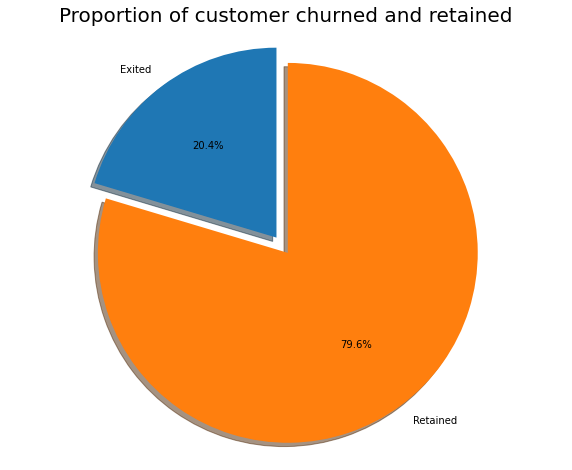

In [70]:
labels = 'Exited', 'Retained'
sizes = [ds.Exited[ds['Exited']==1].count(), ds.Exited[ds['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

* About 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained

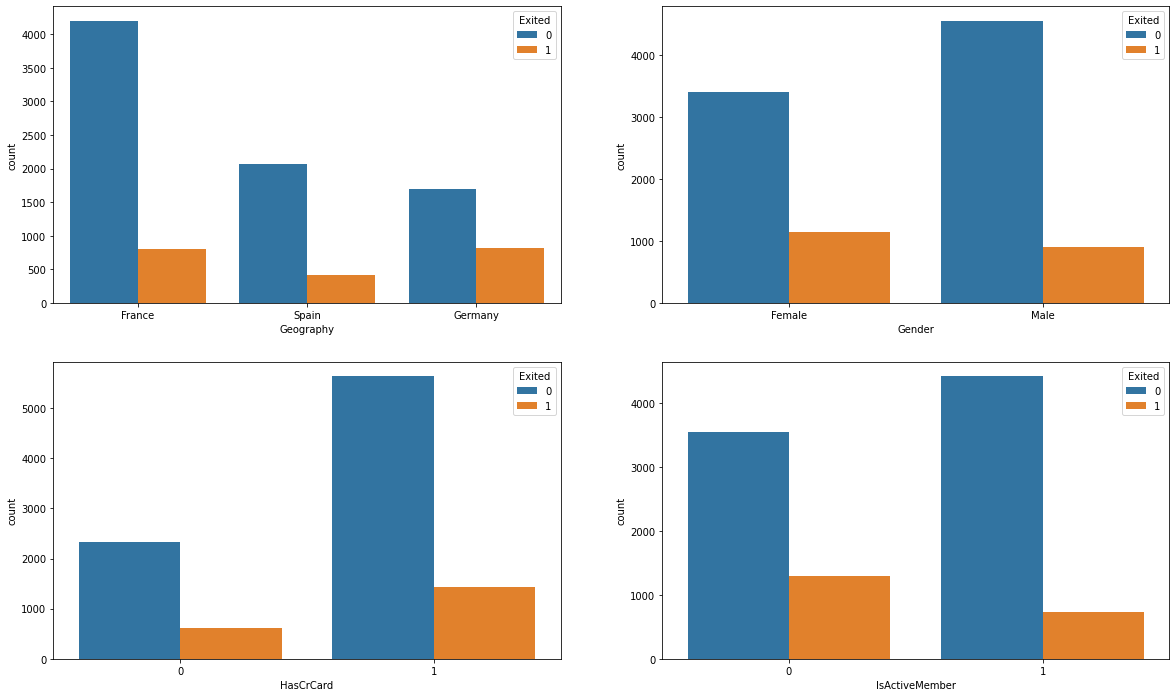

In [71]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = ds, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = ds, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = ds, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = ds, ax=axarr[1][1])

We note the following:

*  Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.

* The proportion of female customers churning is also greater than that of male customers
Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.


* Unsurprisingly the inactive members have a greater churn. 
Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn

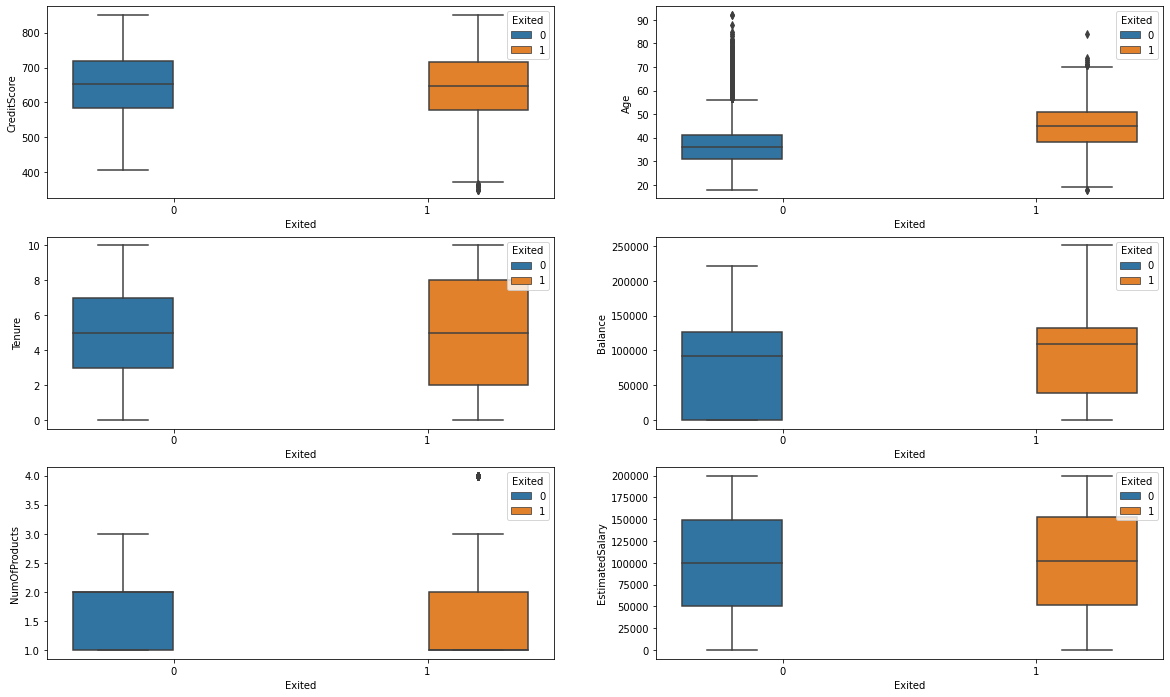

In [72]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = ds , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = ds, ax=axarr[2][1])

We note the following:

* There is no significant difference in the credit score distribution between retained and churned customers.
The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups

* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.

* Neither the product nor the salary has a significant effect on the likelihood to churn

**Insights :** 
* No correlation observed between the  columns

* Exited Customers seem to be distributed across all Credit Scores

* Lot of Customers customers aged between 40-60 seem to have exited the bank 

* Lot of  customers with 3-4 products seem to have exited the bank

* Customers with or without credit cards seem to have exited the bank

* Lot of  customers who are non active members seem to have exited the bank

* Customers across all Estimated Salaries seem to have exited the bank uniformly

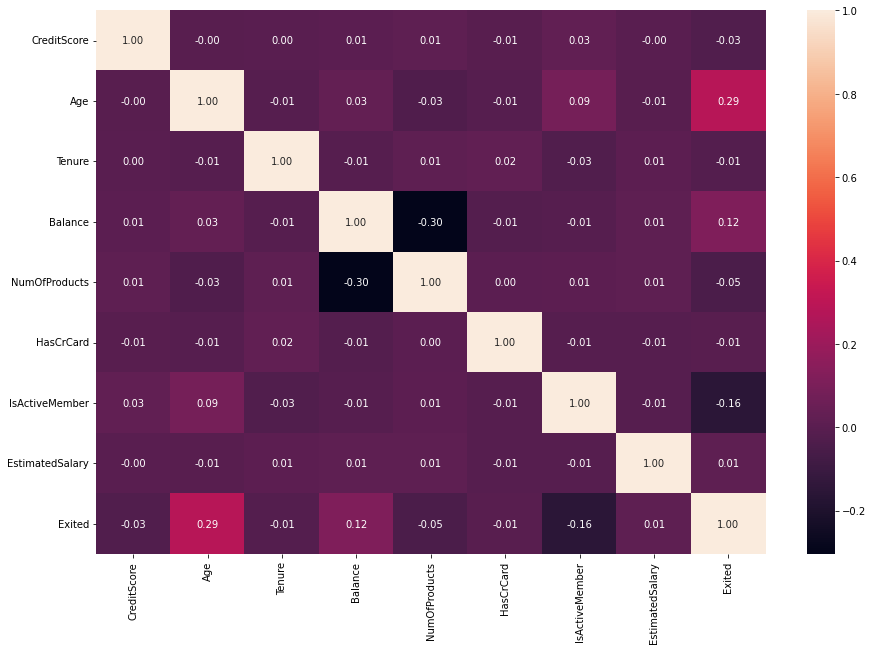

In [73]:
plt.figure(figsize = (15, 10))
sns.heatmap(ds.corr(), annot = True, fmt = '0.2f')

**Insights :** None of the columns are strongly corelated with each other. There is no multicollinearity.

#### Distinguish the feature and target set

In [74]:
X = ds.iloc[:,0:10].values # Credit Score through Estimated Salary
y = ds.iloc[:,10].values # Exited

## Categorical Encoding

In [76]:
# We will do the same thing for gender. this will be binary in this dataset
print(X[:6,2], '... will now become: ')

label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


In [77]:



# Converting the string features into their own dimensions. Gender doesn't matter here because its binary
#countryhotencoder = OneHotEncoder(categories = [1]) # 1 is the country column
countryhotencoder = ColumnTransformer([("countries", OneHotEncoder(), [1])], remainder="passthrough")
X = countryhotencoder.fit_transform(X)
#X = countryhotencoder.fit_transform(X).toarray()

In [78]:
#Printing the shape of the data 
X.shape

(10000, 12)

In [79]:
#Printing the data
X 

array([[1.0, 0.0, 0.0, ..., 1, 1, 101348.88],
       [0.0, 0.0, 1.0, ..., 0, 1, 112542.58],
       [1.0, 0.0, 0.0, ..., 1, 0, 113931.57],
       ...,
       [1.0, 0.0, 0.0, ..., 0, 1, 42085.58],
       [0.0, 1.0, 0.0, ..., 1, 0, 92888.52],
       [1.0, 0.0, 0.0, ..., 1, 0, 38190.78]], dtype=object)

In [80]:

# A 0 on two countries means that the country has to be the one variable which wasn't included 
# This will save us from the problem of using too many dimensions
X = X[:,1:] # Got rid of Spain as a dimension.

#### Divide the data set into Train and test sets

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

#### Normalize the train and test data

In [82]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [91]:

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting a customer is exiting  and the customer  is not exiting
* Predicting a customer is not exiting and  customer is  exiting

### Which case is more important? 
* Predicting that customer is not exiting but he/she is exiting. It might cause loss to the banks because due to wrong identification bank will not be able to take any initiative for those sensitive customers. 

### How to reduce this loss i.e need to reduce False Negative?
* Bank would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the bank can retain their customers.

As you can see, the above model has good accuracy and precision but have poor recall. There can be two reasons as follows:

1) **Imbalanced dataset:** As you have seen in the EDA, This dataset is imbalanced and it contains more examples belong to non_exited class (0).

2) **Inappropriate loss function:** We're using MSE loss function which is not appropriate for the classification problem because it tries to minimize the mean ( Central value ) and here the dataset is imbalanced and mean is more biased towards 0th class.

3) **Decision Threshold** As you see this dataset is imbalance. Therefore, we can use ROC-AUC to find the optimal threshold and use the same for prediction.

Lets try to  change the loss function, tune the decision threshold, apply SMOTE to balance the dataset and   configure some other hyperparameters accordingly 

**Changing the loss function to binary_crossentropy which is used for binary classification**

In [93]:
import keras
keras.backend.clear_session()

In [94]:
def create_model():
      #Initializing the neural network
      model = Sequential()
      #Adding the hidden and output layers
      model.add(Dense(64,activation='relu',input_dim = X_train.shape[1]))
      model.add(Dropout(0.2))
      model.add(Dense(32,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(32,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(32,activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation = 'sigmoid'))
      #Compiling the ANN with RMSprop optimizer and binary cross entropy loss function 
      optimizer = tf.keras.optimizers.Adam(0.001)
      model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
      return model

In [95]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [96]:
#Fitting the ANN with batch_size = 32 and 100 epochs 
history = model.fit(X_train,y_train,batch_size=32,epochs=100,verbose=1,validation_split = 0.2)

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5037 - accuracy: 0.7816 - val_loss: 0.4229 - val_accuracy: 0.8213
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4524 - accuracy: 0.8047 - val_loss: 0.4059 - val_accuracy: 0.8244
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4316 - accuracy: 0.8159 - val_loss: 0.3816 - val_accuracy: 0.8400
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4052 - accuracy: 0.8286 - val_loss: 0.3649 - val_accuracy: 0.8456
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3857 - accuracy: 0.8383 - val_loss: 0.3602 - val_accuracy: 0.8512
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3834 - accuracy: 0.8420 - val_loss: 0.3527 - val_accuracy: 0.8525
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3768 - accuracy: 0.8436 - val_loss: 0.3504 - val_accuracy: 0.8600

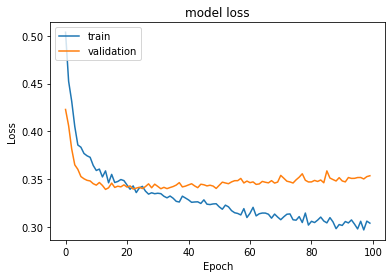

In [97]:
#Plotting Train Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


As you can see from the above image, this model is severely overfitting. Deep learning models are very senstive to overfititng due to large amount of parameters. We need to find the optimal point where the training should be stopped. 

The best solution for the above problem is **Early stopping**.

**Early stopping:** 

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

In [98]:
keras.backend.clear_session()

In [99]:
#Importing classback API
from keras import callbacks 
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.001)
model_e=create_model()
#Fitting the ANN with batch_size = 32 and 100 epochs 
history_e = model_e.fit(X_train,y_train,batch_size=32,
                        epochs=100,verbose=1,validation_split = 0.2,callbacks=[es_cb, reduce_lr])

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4886 - accuracy: 0.7939 - val_loss: 0.4208 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4433 - accuracy: 0.8075 - val_loss: 0.4049 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8164 - val_loss: 0.3844 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4024 - accuracy: 0.8305 - val_loss: 0.3683 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3843 - accuracy: 0.8411 - val_loss: 0.3556 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.3806 - accuracy: 0.8431 - val_loss: 0.3552 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 7/100
200/200 [==============================] - 1s 3ms/st

Lets plot the loss function again

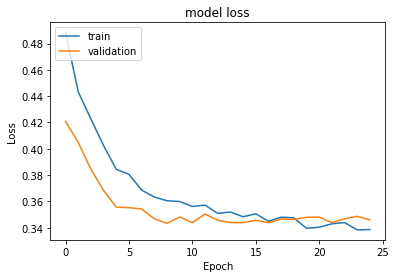

In [100]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_e.history['loss'])
plt.plot(history_e.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


As you can see from the above graph, Training is stopped at the appropriate epoch because after that, loss function started to increase. Therefore, Early stopping prevents the overfitting

Accuracy, Precision, Recall, and F1-Scores

##Hyperparameter Optimization

Some important parameters to look out for while optimizing neural networks are:

-Type of architecture

-Number of Layers

-Number of Neurons in a layer

-Regularization parameters

-Learning Rate

-Type of optimization / backpropagation technique to use

-Dropout rate

-Weight sharing

In [112]:
keras.backend.clear_session()

In [ ]:
def create_model_v2(dropout_rate=0.1,lr=0.001,layer_1=64,neurons=[32,32,32,32]):  
    np.random.seed(1)
    model = Sequential()
    # This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    model.add(Dense(layer_1,activation='relu',input_dim = X_train.shape[1]))
    #Adding dropout layer
    n = len(neurons)+1
    model.add(Dropout(dropout_rate))
    for x in range(1,n-1):
        model.add(Dense(neurons[x-1],activation='relu'))
        model.add(Dropout(dropout_rate))
    # we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
    # We use the sigmoid because we want probability outcomes
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

##### Number of Layers:
We will keep it similar to the above model so that we can compare the accuracy.
1 hidden layer.

##### Activation:
input layer: relu becasue we are in an input layer. uses the ReLu activation function for  ϕ
output layer: sigmoid becasue we are in an output layer. uses the Sigmoid activation function for  ϕ . This is used instead of the ReLu function becasue it generates probabilities for the outcome. We want the probability that each customer leaves the bank.

##### Type of optimization / backpropagation technique to use: 
We will use Adam. Adam is a very efficeint variation of Stochastic Gradient Descent. For Adam and its variant, learning rate or the decay rate does not really matter too much.

##### Learning Rate:
default learning rate 0.001.

##### Number of Neurons in a layer:
We will keep it 6 as per our initial calculation above.

##### Weight sharing / kernel_initializer: 
uniform the distribution with which we randomly initialize weights for the nodes in this layer.

##### Loss:
loss: binary_crossentropy This is the loss function used within adam. This should be the logarthmic loss. If our dependent (output variable) is Binary, it is binary_crossentropy. If Categorical, then it is called categorical_crossentropy

Rebuilding the model using these optimised parameters


Let's try to use drop out to reduce  overfitting. Here, we will not be using earlystopping because earlystopping also have some drawbacks. We should try using it with the complex models

In [113]:
def create_model_v2(dropout_rate=0.1,lr=0.001,layer_1=64,layer_2=32):  
    np.random.seed(1)
    model = Sequential()
    # This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    model.add(Dense(layer_1,activation='relu',input_dim = X_train.shape[1]))
    #Adding dropout layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_2,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_2,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_2,activation='relu'))
    model.add(Dropout(dropout_rate))
    # # Adding the hidden layer
    # Notice that we do not need to specify input dim. 
    model.add(Dense(layer_2,activation='relu'))
    # # Adding the output layer
    # Notice that we do not need to specify input dim. 
    # we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
    # We use the sigmoid because we want probability outcomes
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

##Using Grid search

We are using grid search to optimize thwo hyperparameters called **batch size, epochs** due to the limited time. But you can optimize the other hyperparameters as mentioned above

In [114]:
keras_estimator = KerasClassifier(build_fn=create_model_v2, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [115]:
# define the grid search parameters
param_grid = {
    'batch_size':[40, 64, 128],
    "lr":[0.01,0.001,0.1],
    "layer_2": [32,64,16],
    "dropout_rate":[.1,.2]
   
    
}

grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=5,  
                    param_grid=param_grid,n_jobs=-1)

In [116]:
grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 3 folds for each of 54 candidates, totalling 162 fits
100/100 [==============================] - 1s 5ms/step - loss: 0.4369 - accuracy: 0.8208 - val_loss: 0.3645 - val_accuracy: 0.8487
Best: 0.839999 using {'batch_size': 64, 'dropout_rate': 0.1, 'layer_2': 64, 'lr': 0.01}


##Let's create the final model with above mentioned configuration

In [121]:
keras.backend.clear_session()

In [122]:
estimator_v2=create_model_v2(lr=grid_result.best_params_['lr'], dropout_rate=.1,
                             layer_2= 64)

estimator_v2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [123]:

history_h=estimator_v2.fit(X_train, y_train, epochs=100, batch_size = grid_result.best_params_['batch_size'],
                           callbacks=[es_cb, reduce_lr], verbose=1,validation_split=0.2)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.4501 - accuracy: 0.7997 - val_loss: 0.3787 - val_accuracy: 0.8375 - lr: 0.0100
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.8355 - val_loss: 0.4044 - val_accuracy: 0.8419 - lr: 0.0100
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3699 - accuracy: 0.8511 - val_loss: 0.3565 - val_accuracy: 0.8469 - lr: 0.0100
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8559 - val_loss: 0.3629 - val_accuracy: 0.8631 - lr: 0.0100
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3619 - accuracy: 0.8527 - val_loss: 0.3496 - val_accuracy: 0.8569 - lr: 0.0100
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3492 - accuracy: 0.8581 - val_loss: 0.3537 - val_accuracy: 0.8512 - lr: 0.0100
Epoch 7/100
100/100 [==============================] - 0s 4ms/st

Plotting the validation and training loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'middle'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


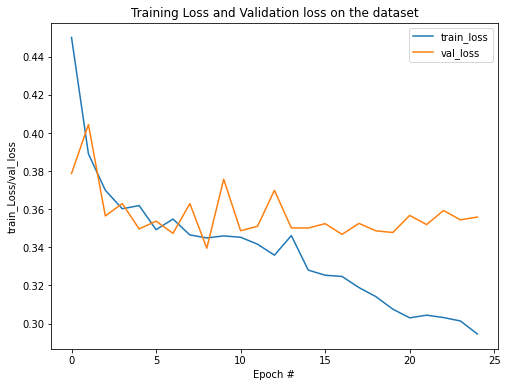

In [125]:
N =25
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_h.history["val_loss"], label="val_loss")

plt.title("Training Loss and Validation loss on the dataset")
plt.xlabel("Epoch #")
plt.ylabel("train_Loss/val_loss")
plt.legend(loc="middle")
plt.show()

As you can seen , the above model's validation curve does not have high slope which means it has  not decreased much. Let's check other metrices to understand how this model works 

### Finding the optimal threshold 

Best Threshold=0.257004, G-Mean=0.786


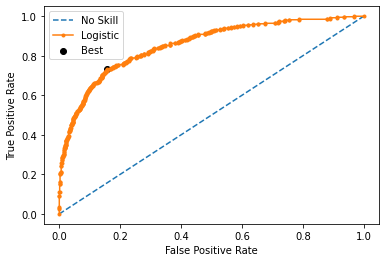

In [128]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot


# predict probabilities
yhat = estimator_v2.predict(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

#### Predict the results using best threshold 

In [126]:
y_pred_h = estimator_v2.predict(X_test)
print(y_pred_h)

[[0.00693965]
 [0.00148493]
 [0.1406095 ]
 ...
 [0.6949972 ]
 [0.16600803]
 [0.26049876]]


In [129]:
# To use the confusion Matrix, we need to convert the probabilities that a customer will leave the bank into the form true or false. 
# So we will use the tuned cutoff value to indicate whether they are likely to exit or not.
y_pred_h = (y_pred_h > thresholds[ix])
print(y_pred_h)

[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [ True]]


#### Print the confusion matrix

In [130]:
#lets print classification report
from sklearn import metrics
cr=metrics.classification_report(y_test,y_pred_h)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1607
           1       0.53      0.73      0.62       393

    accuracy                           0.82      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.82      0.83      2000



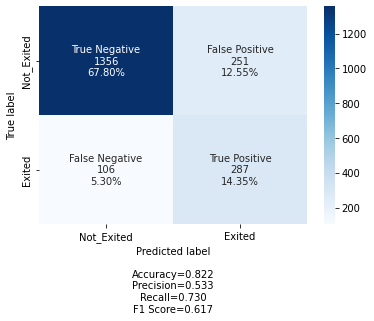

In [131]:


#Calculating the confusion matrix 
cm_h=confusion_matrix(y_test, y_pred_h)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm_h, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

##**Conclusion:**

* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups

* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure. Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.

* The proportion of female customers churning is also greater than that of male customers
Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.


* Unsurprisingly the inactive members have a greater churn. 
Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn



#### The optimised model gives better results as seen from the confusion matrix as well as improved accuracy.

